* Python API : https://aws.amazon.com/sdk-for-python/
* Rekognition docs : https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/rekognition.html
* Labels from local file : https://github.com/awsdocs/amazon-rekognition-developer-guide/blob/master/code_examples/python_examples/image/python-detect-labels-local-file.py
* AWS regions https://docs.aws.amazon.com/AmazonRDS/latest/UserGuide/Concepts.RegionsAndAvailabilityZones.html
* [Tensorflow component save image function](https://github.com/home-assistant/home-assistant/blob/30841ef4da692cb5d12b26fe08271fdf87c8c992/homeassistant/components/image_processing/tensorflow.py#L231)
* Only return data with an instance cound > 0 in order to limit data to objects

In [1]:
pwd

'/Users/robin/Documents/jupyter/rekognition/development'

In [2]:
#!pip3 install boto3

In [3]:
#!pip3 install matplotlib
#!pip3 install Pillow

In [4]:
#rgb(red, green, blue)
RED = (255, 0, 0)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)
YELLOW = (255, 255, 0)

In [5]:
import base64
import boto3
import json
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

FIG_SIZE = (12, 8)

def load_api_secrets(filename):
    """Convenience to load the API key from a json file."""
    try:
        with open(filename, 'r') as fp:
            file_contents = json.load(fp)
            return file_contents
    except Exception as exc:
        print(exc)

In [6]:
boto3.__version__

'1.13.2'

In [7]:
!ls

aws-creds.json    development.ipynb people.jpg        usage.png
boxed_image.jpg   dog.jpg           people_car.jpg
car.jpg           obama.jpg         street.jpg


In [8]:
# imageFile='people.jpg'
imageFile='people_car.jpg'
#imageFile='street.jpg'
#imageFile='dog.jpg'
#imageFile='obama.jpg'

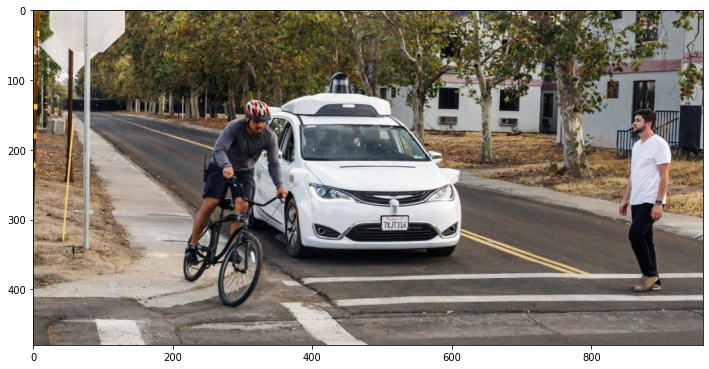

In [9]:
img = plt.imread(imageFile)
fig, ax = plt.subplots(figsize=FIG_SIZE)
ax.imshow(img);

We authenticate with amazon using a dict:
    
```python
aws_config = {
        CONF_REGION: config.get(CONF_REGION),
        CONF_ACCESS_KEY_ID: config.get(CONF_ACCESS_KEY_ID),
        CONF_SECRET_ACCESS_KEY: config.get(CONF_SECRET_ACCESS_KEY),
    }
```

We can load these credentials from a json file

In [10]:
aws_config = load_api_secrets("aws-creds.json")
#aws_config

My actual credentials are offline

In [11]:
client=boto3.client('rekognition', **aws_config)

In [12]:
try:
    client.detect_labels(Image={'Bytes': b"test"})
except Exception as exc:
    if 'UnrecognizedClientException' in str(exc):
        print(str(exc).split(':')[-1])
    else:
        print("Credentials are OK")

Credentials are OK


## Labels
Post the image file with [detect_labels](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/rekognition.html#Rekognition.Client.detect_labels)

In [13]:
%%time
with open(imageFile, 'rb') as image:
    try:
        response = client.detect_labels(Image={'Bytes': image.read()})
    except Exception as exc:
        print(exc)

CPU times: user 7.39 ms, sys: 2.3 ms, total: 9.7 ms
Wall time: 1.22 s


In [14]:
response

{'Labels': [{'Name': 'Person',
   'Confidence': 99.85315704345703,
   'Instances': [{'BoundingBox': {'Width': 0.0759148895740509,
      'Height': 0.5483436584472656,
      'Left': 0.8748960494995117,
      'Top': 0.2920868694782257},
     'Confidence': 99.85315704345703},
    {'BoundingBox': {'Width': 0.15320314466953278,
      'Height': 0.515958845615387,
      'Left': 0.22776539623737335,
      'Top': 0.2583009898662567},
     'Confidence': 99.78672790527344}],
   'Parents': []},
  {'Name': 'Human',
   'Confidence': 99.85315704345703,
   'Instances': [],
   'Parents': []},
  {'Name': 'Bicycle',
   'Confidence': 99.8502426147461,
   'Instances': [{'BoundingBox': {'Width': 0.13132628798484802,
      'Height': 0.3868344724178314,
      'Left': 0.22395403683185577,
      'Top': 0.5006230473518372},
     'Confidence': 99.8502426147461}],
   'Parents': [{'Name': 'Vehicle'}, {'Name': 'Transportation'}]},
  {'Name': 'Bike',
   'Confidence': 99.8502426147461,
   'Instances': [],
   'Parents':

In [15]:
def get_object_instances(
    response: str, target: str, confidence_threshold: float
) -> int:
    """Get the number of instances of a target object above the confidence threshold."""
    for label in response["Labels"]:
        if (
            label["Name"].lower() == target.lower()
        ):  # Lowercase both to prevent any comparing issues
            confident_labels = [
                l for l in label["Instances"] if l["Confidence"] > confidence_threshold
            ]
            return confident_labels
    return []


def get_objects(response: str) -> dict:
    """Parse the data, returning detected objects only."""
    return {
        label["Name"].lower(): round(label["Confidence"], 1)
        for label in response["Labels"]
        if len(label["Instances"]) > 0
    }

In [16]:
get_objects(response)

{'person': 99.9, 'bicycle': 99.9, 'wheel': 99.5, 'car': 99.4, 'shoe': 97.6}

In [17]:
get_object_instances(response, 'person', 80.0)

[{'BoundingBox': {'Width': 0.0759148895740509,
   'Height': 0.5483436584472656,
   'Left': 0.8748960494995117,
   'Top': 0.2920868694782257},
  'Confidence': 99.85315704345703},
 {'BoundingBox': {'Width': 0.15320314466953278,
   'Height': 0.515958845615387,
   'Left': 0.22776539623737335,
   'Top': 0.2583009898662567},
  'Confidence': 99.78672790527344}]

In [18]:
bounding_boxes = [i['BoundingBox'] for i in get_object_instances(response, 'person', 80.0)]
bounding_boxes

[{'Width': 0.0759148895740509,
  'Height': 0.5483436584472656,
  'Left': 0.8748960494995117,
  'Top': 0.2920868694782257},
 {'Width': 0.15320314466953278,
  'Height': 0.515958845615387,
  'Left': 0.22776539623737335,
  'Top': 0.2583009898662567}]

## Draw bounding boxes

In [19]:
from PIL import Image, ImageDraw
from typing import Tuple

def draw_box(
    draw: ImageDraw,
    box: Tuple[float, float, float, float],
    img_width: int,
    img_height: int,
    text: str = "",
    color: Tuple[int, int, int] = (255, 255, 0),
) -> None:
    """
    Draw a bounding box on and image.
    The bounding box is defined by the tuple (y_min, x_min, y_max, x_max)
    where the coordinates are floats in the range [0.0, 1.0] and
    relative to the width and height of the image.
    For example, if an image is 100 x 200 pixels (height x width) and the bounding
    box is `(0.1, 0.2, 0.5, 0.9)`, the upper-left and bottom-right coordinates of
    the bounding box will be `(40, 10)` to `(180, 50)` (in (x,y) coordinates).
    """

    line_width = 3
    font_height = 8
    y_min, x_min, y_max, x_max = box
    (left, right, top, bottom) = (
        x_min * img_width,
        x_max * img_width,
        y_min * img_height,
        y_max * img_height,
    )
    draw.line(
        [(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
        width=line_width,
        fill=color,
    )
    if text:
        draw.text(
            (left + line_width, abs(top - line_width - font_height)), text, fill=color
        )

## Working with shapes
We borrow idea from geospatial of having primitive objects and points, on which we can do calculations. Keep the naming similar to that used in Shapely -> https://shapely.readthedocs.io/en/latest/manual.html#geometric-objects, but note they use different conventions, e.g. `box(minx, miny, maxx, maxy)`

Calculate area of overlap -> https://stackoverflow.com/questions/27152904/calculate-overlapped-area-between-two-rectangles#27162334

In [20]:
from collections import namedtuple
Box = namedtuple('Box', 'y_min x_min y_max x_max')
Point = namedtuple('Point', 'y x')

In [21]:
roi_x_min = 0.1
roi_x_max = 0.5
roi_y_min = 0.1
roi_y_max = 0.7

#roi = (roi_ymin, roi_xmin, roi_ymax, roi_xmax) # our region of interest
#roi

In [22]:
roi = Box(roi_y_min, roi_x_min, roi_y_max, roi_x_max)
roi

Box(y_min=0.1, x_min=0.1, y_max=0.7, x_max=0.5)

In [23]:
point_inside = Point(0.2, 0.15)
point_outside = Point(0.01, 0.01)

In [24]:
def point_in_box(box : Box, point : Point) -> bool:
    """Return true if point lies in box"""
    if (box.x_min <= point.x <= box.x_max) and (box.y_min <= point.y <= box.y_max):
        return True
    return False

point_in_box(roi, point_inside)      

True

In [25]:
point_in_box(roi, point_outside)    

False

In [26]:
img = Image.open(imageFile)
draw = ImageDraw.Draw(img)

draw_box(draw, (roi_y_min, roi_x_min, roi_y_max, roi_x_max), img.width, img.height, color=GREEN)

for box in bounding_boxes:
    x_min, y_min, w, h = box["Left"], box["Top"], box["Width"], box["Height"]
    x_max, y_max = x_min + w, y_min + h
    
    # Get box center
    center_x, center_y = (x_min + w/2), (y_min + h/2)
    box_center = Point(center_y, center_x)
    point_in_box(roi, box_center)     
    print(f'{box_center} is inside {roi}?: {point_in_box(roi, box_center)}')

    object_box = (y_min, x_min, y_max, x_max)
    draw_box(
        draw, object_box, img.width, img.height,
    )
    
    # Draw the bullsey
    centroid = (center_x*img.width, center_y*img.height)
    draw.text(centroid, text='X', fill=(255, 255, 0))

Point(y=0.5662586987018585, x=0.9128534942865372) is inside Box(y_min=0.1, x_min=0.1, y_max=0.7, x_max=0.5)?: False
Point(y=0.5162804126739502, x=0.30436696857213974) is inside Box(y_min=0.1, x_min=0.1, y_max=0.7, x_max=0.5)?: True


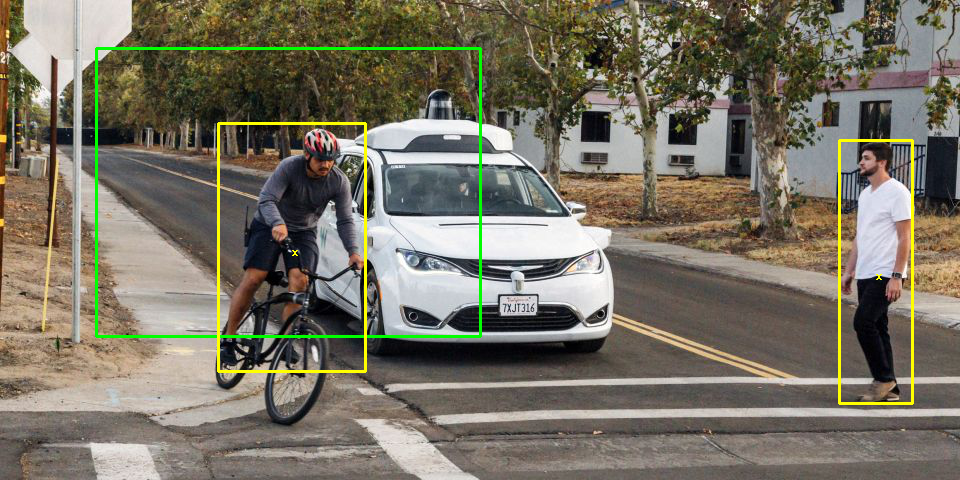

In [27]:
img